# Logistic Regression

In [20]:
library(visdat)
library(tidyverse)
library(dummies)

dummies-1.5.6 provided by Decision Patterns



## Titanic data: predict survival


<img src="titanic.png",width=800,height=300 >
[Image via Wikimedia Commons]

### Explore + visualize data

In [4]:
titanic <- read.csv('../../data/titanic/titanic.csv')
head(titanic, 5)

Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
22,,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0,A/5 21171
38,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",0,2,1,female,1,1,PC 17599
26,,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1,STON/O2. 3101282
35,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1,113803
35,,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0,373450


#### Data Dictionary 

|Variable|	Definition	|Key|
|---|---|---|
|survival	|Survival|	0 = No, 1 = Yes|
|pclass	|Ticket class	|1 = 1st, 2 = 2nd, 3 = 3rd|
|sex	|Sex	||
|Age	|Age in years	||
|sibsp	|# of siblings / spouses aboard the Titanic	||
|parch	|# of parents / children aboard the Titanic	||
|ticket	|Ticket number	||
|fare	|Passenger fare	||
|cabin	|Cabin number	||
|embarked	|Port of Embarkation|	C = Cherbourg, Q = Queenstown, S = Southampton|


Variable Notes
pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

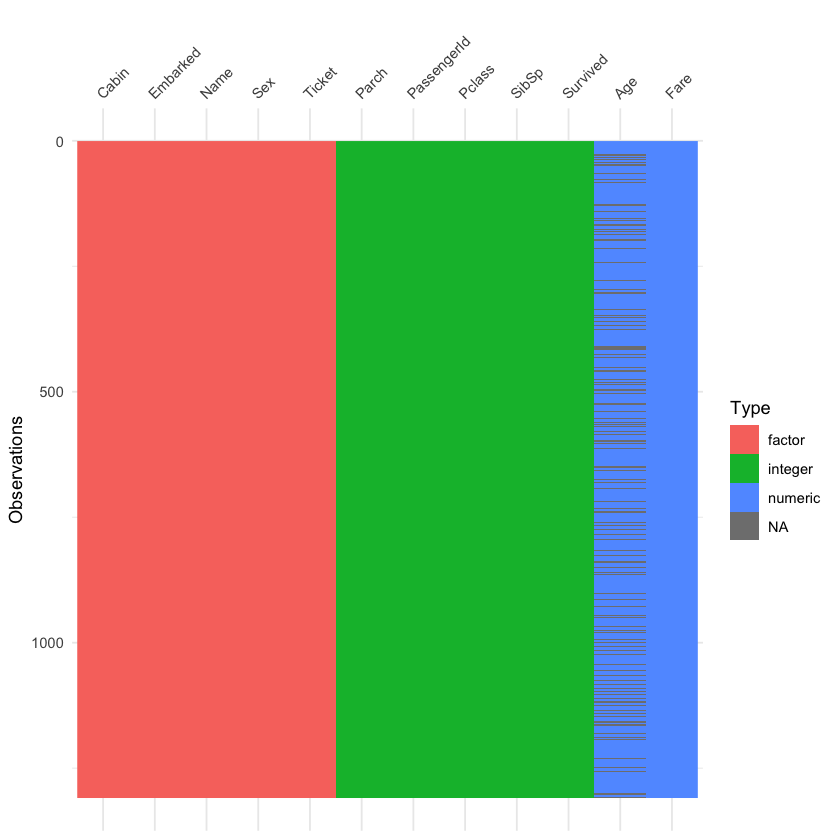

In [5]:
vis_dat(titanic)

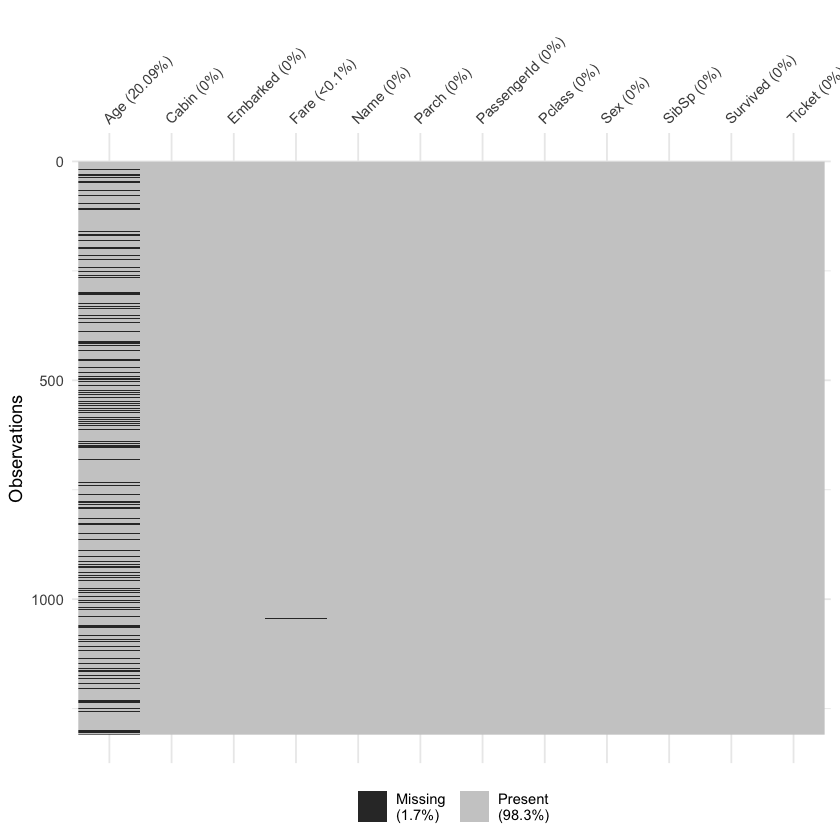

In [6]:
vis_miss(titanic)

### Feature Engineering

Note: beware of "leakage" between training and test sets. I'm doing everything on one dataset here; we might not want to do that in practice.

Here are a few feature engineering steps we can take: 
1. Create a "family members" variable which is the sum of parents / children and siblings / spouses.
2. Remove variables we don't want to use for prediction, like personal identifiers.
3. Replace missing values in age with the average value of age. 
4. Make dummy variables for Embarked, Sex, and Passenger Class.

In [26]:
titanic_clean <- titanic %>%
mutate(family_members = Parch + SibSp) %>%
select(-c(Cabin, PassengerId, Ticket, Name))

titanic_clean$Age[is.na(titanic_clean$Age)] = as.integer(round(mean(titanic$Age, na.rm = TRUE), 0))
titanic_clean <- dummy.data.frame(titanic_clean, names=c("Pclass","Sex","Embarked"), sep="_")

head(titanic_clean, 3)

Age,Embarked_,Embarked_C,Embarked_Q,Embarked_S,Fare,Parch,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,SibSp,Survived,family_members
22,0,0,0,1,7.2500,0,0,0,1,0,1,1,0,1
38,0,1,0,0,71.2833,0,1,0,0,1,0,1,1,1
26,0,0,0,1,7.9250,0,0,0,1,1,0,0,1,0


### Split Test + Training Sets

In [27]:
set.seed(10)

train_ind <- sample(nrow(titanic_clean), round(nrow(titanic_clean) * 0.9))
train <- titanic_clean[train_ind,]
test <- titanic_clean[-train_ind, ]

head(train, 6)

,Age,Embarked_,Embarked_C,Embarked_Q,Embarked_S,Fare,Parch,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,SibSp,Survived,family_members
665,20.0,0,0,0,1,7.9250,0,0,0,1,0,1,1,1,1
402,26.0,0,0,0,1,8.0500,0,0,0,1,0,1,0,0,0
558,30.0,0,1,0,0,227.5250,0,1,0,0,0,1,0,0,0
906,47.0,0,0,0,1,61.1750,0,1,0,0,1,0,1,1,1
112,14.5,0,1,0,0,14.4542,0,0,0,1,1,0,1,0,1
294,24.0,0,0,0,1,8.8500,0,0,0,1,1,0,0,0,0


### Build Logistic Model

In [28]:
logistic_fit <- glm(Survived ~.,family=binomial(link='logit'),data=train)

In [30]:
summary(logistic_fit)


Call:
glm(formula = Survived ~ ., family = binomial(link = "logit"), 
    data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.7615  -0.5079  -0.3521   0.4891   2.5684  

Coefficients: (4 not defined because of singularities)
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)     -1.700592   0.265871  -6.396 1.59e-10 ***
Age             -0.035707   0.007727  -4.621 3.82e-06 ***
Embarked_       12.224275 614.278850   0.020 0.984123    
Embarked_C       0.179317   0.231731   0.774 0.439041    
Embarked_Q       0.583435   0.324920   1.796 0.072554 .  
Embarked_S             NA         NA      NA       NA    
Fare             0.002869   0.002158   1.329 0.183805    
Parch           -0.094568   0.101785  -0.929 0.352839    
Pclass_1         1.950760   0.286947   6.798 1.06e-11 ***
Pclass_2         1.032410   0.233466   4.422 9.77e-06 ***
Pclass_3               NA         NA      NA       NA    
Sex_female       3.704568   0.200083  18.515 

In [32]:
predict_logistic = predict(logistic_fit, type = "response", newdata = test)
predict_logistic = ifelse(predict_logistic > .5, 1, 0)

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
“prediction from a rank-deficient fit may be misleading”

In [38]:
titanic_predictions <- data.frame(actual = test$Survived, predicted = predict_logistic) %>%
mutate(correct_prediction = ifelse(actual == predicted, 1, 0))

head(titanic_predictions, 5)

actual,predicted,correct_prediction
1,1,1
0,0,1
1,1,1
1,1,1
1,1,1


### Evaluate performance

In [39]:
correct_logistic = round(mean(titanic_predictions$correct_prediction, na.rm = TRUE), 4)*100
print(paste("We were correct", correct_logistic, "% of the time"))

[1] "We were correct 84.62 % of the time"


Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
“prediction from a rank-deficient fit may be misleading”

[1] 0.9020606

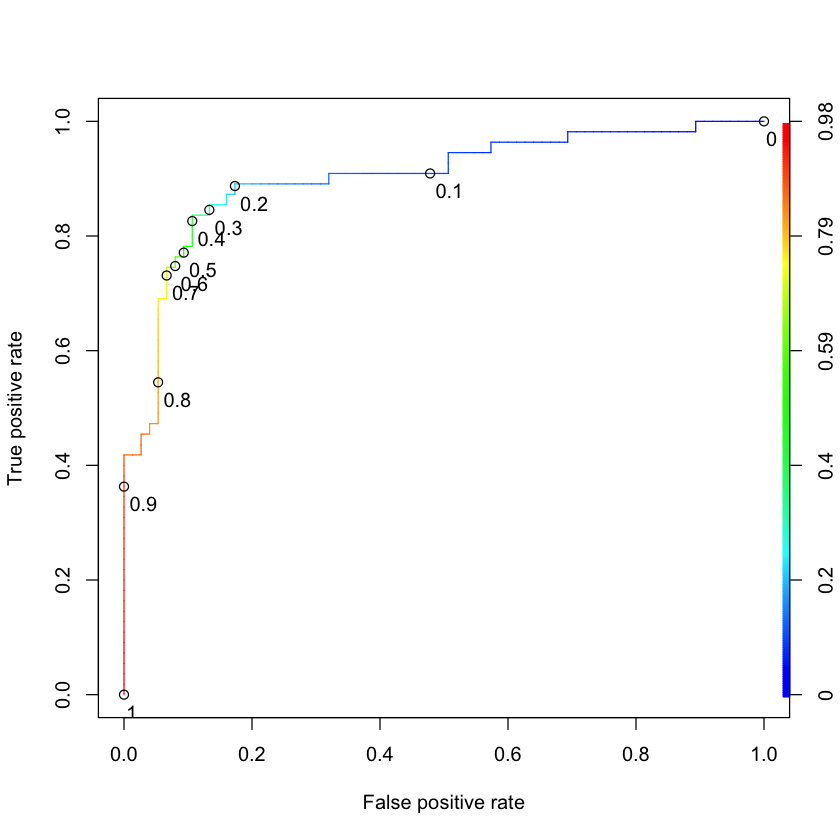

In [42]:
library(ROCR)
predictions <- predict(logistic_fit, newdata=test, type="response")
ROCRpred <- prediction(predictions, test$Survived)
ROCRperf <- performance(ROCRpred, measure = "tpr", x.measure = "fpr")

plot(ROCRperf, colorize = TRUE, text.adj = c(-0.2,1.7), print.cutoffs.at = seq(0,1,0.1))

auc <- performance(ROCRpred, measure = "auc")
auc <- auc@y.values[[1]]
auc